# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Type, Optional
import pandera as pa
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta

import meteostat as met

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam



In [12]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [13]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [14]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [15]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [16]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [17]:
# timeseries data breakout
df["DAY_NAME"] = df["DATETIME"].dt.day_name()
df["MONTH"] = df["DATETIME"].dt.month
df["YEAR"] = df["DATETIME"].dt.year
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [18]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,DAY_NAME,MONTH,YEAR,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [19]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [20]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [21]:
combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [22]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

mean_wdat = pd.concat([mean_wdat, sun_data], axis=1)[:-1]

In [23]:
mean_wdat.head()

,tavg,wspd,sun_eff
2011-01-01,5.300,14.400,0.018301
2011-02-01,7.500,18.000,0.026512
2011-03-01,8.925,15.775,0.068665
2011-04-01,13.100,13.550,0.117791
2011-05-01,13.580,14.300,0.125091


Since I have to break this dataset into training, validation, and testing sets, I skip 2020 because I cannot train on it without the risk of overfitting at this timeframe (monthly/LTLF) and the data is anomalous. Perhaps in a later iteration I might add a dummy to the input layer that checks for 2020, but at this time we will keep things simple.

In [136]:
ltoc = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

In [137]:
scaler_ltoc = MinMaxScaler(feature_range=(0, 1))

In [138]:
agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [139]:
def col_Xy(col: Series, seasonal_order: int) -> (np.ndarray, np.ndarray):
  col
  X = []
  y = []
  for i in range(len(col)-seasonal_order):
    window = [a for a in col[i:i+seasonal_order]]
    X.append(window)
    label = col[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

In [140]:
SEASON_LTLF = 11

In [141]:
Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)

In [142]:
Xtr_ltoc[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [143]:
ytr_ltoc[0]

array([0.82318279])

In [144]:
Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)

### Running the LTLF

In [145]:

ltoc_model = Sequential()
ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
ltoc_model.add(LSTM(128, return_sequences=True))
ltoc_model.add(LSTM(128))
ltoc_model.add(Dense(8, 'relu'))
ltoc_model.add(Dense(1, 'linear'))

ltoc_model.summary()

Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_326 (LSTM)                 │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_327 (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
cp = ModelCheckpoint('models/ltoc_model.keras', save_best_only=True)
ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [147]:
ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 0.2007 - root_mean_squared_error: 0.4476 - val_loss: 0.1334 - val_root_mean_squared_error: 0.3652
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1006 - root_mean_squared_error: 0.3159 - val_loss: 0.1310 - val_root_mean_squared_error: 0.3620
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0729 - root_mean_squared_error: 0.2699 - val_loss: 0.1170 - val_root_mean_squared_error: 0.3420
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0660 - root_mean_squared_error: 0.2567 - val_loss: 0.1167 - val_root_mean_squared_error: 0.3416
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0655 - root_mean_squared_error: 0.2557 - val_loss: 0.1134 - val_root_mean_squared_error: 0.3367
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0540 - root_mean_squared_error: 0.2321 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3360
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0598 - roo

In [148]:
ltoc_model = load_model('models/ltoc_model.keras')

In [149]:
pred_ltoc = ltoc_model.predict(Xts_ltoc)
pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)

yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


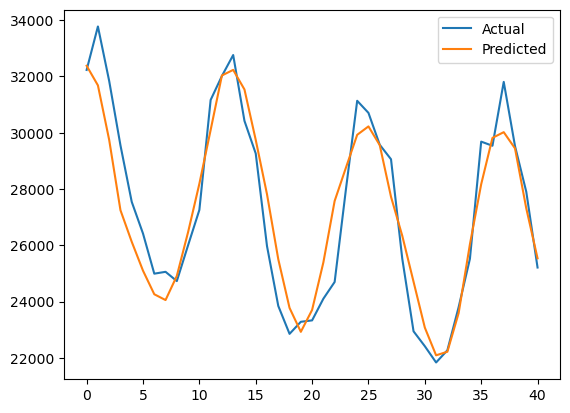

In [150]:
plt.plot(yts_ltoc, label='Actual')
plt.plot(pred_ltoc, label='Predicted')
plt.legend()
plt.show()

In [151]:
print(f"MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%")

MAPE: 3.391%


### LTLF with Exogenous Variables

In [152]:
def df_Xy(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  df
  X = []
  y = []
  for i in range(len(df)-seasonal_order):
    row = [a for a in df[i:i+seasonal_order]]
    X.append(row)
    label = df[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

In [153]:
ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

In [154]:
scaler_ltmc = MinMaxScaler(feature_range=(0, 1))

sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)

In [155]:
ltmc_model = Sequential()
ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
ltmc_model.add(LSTM(512, return_sequences=True))
ltmc_model.add(LSTM(256))
ltmc_model.add(Dense(32, 'relu'))
ltmc_model.add(Dense(4, 'linear'))

ltmc_model.summary()

Model: "sequential_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_328 (LSTM)                 │ (None, 11, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_329 (LSTM)                 │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
cp = ModelCheckpoint('models/ltmc_model.keras', save_best_only=True)
ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - loss: 0.2324 - root_mean_squared_error: 0.4818 - val_loss: 0.1355 - val_root_mean_squared_error: 0.3681
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0902 - root_mean_squared_error: 0.3002 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3516
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0832 - root_mean_squared_error: 0.2883 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2810
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0540 - root_mean_squared_error: 0.2323 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2806
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0546 -

In [157]:
ltmc_model = load_model('models/ltmc_model.keras')
pred_ltmc = ltmc_model.predict(Xts_ltmc)
pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]

yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


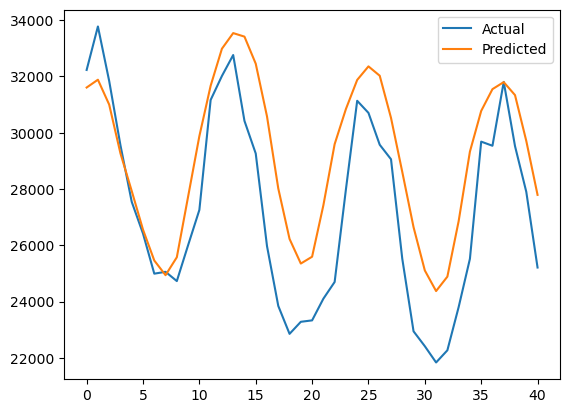

MAPE: 7.832%


In [158]:
plt.plot(yts_ltmc, label='Actual')
plt.plot(pred_ltmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_ltmc, pred_ltmc)*100:.3f}%")

### STLF

In [159]:
SEASON_STLF = 6

In [160]:
stoc = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [161]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [162]:
ldn_wdat_dly = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat_dly = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat_dly = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [163]:
combined_wdat_dly = pd.concat([ldn_wdat_dly, edi_wdat_dly, cdf_wdat_dly], axis=1)

mean_wdat_dly = combined_wdat_dly.T.groupby(combined_wdat_dly.columns).agg("mean").T

In [164]:
sun_factor_09_dly = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_data_dly = sun_factor_09_dly[(sun_factor_09_dly.index >= pd.to_datetime("2022-01-01")) & (sun_factor_09_dly.index <= pd.to_datetime("2022-12-31"))]

mean_wdat_dly = pd.concat([mean_wdat_dly, sun_data_dly], axis=1)

In [165]:
agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")

In [166]:
scaler_stoc = MinMaxScaler(feature_range=(0, 1))

sctr_stoc = scaler_stoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
scvl_stoc = scaler_stoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
scts_stoc = scaler_stoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)

In [167]:
stoc_model = Sequential()
stoc_model.add(InputLayer((SEASON_STLF, 1)))
stoc_model.add(LSTM(128, return_sequences=True))
stoc_model.add(LSTM(128))
stoc_model.add(Dense(8, 'relu'))
stoc_model.add(Dense(1, 'linear'))

stoc_model.summary()

Model: "sequential_225"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_330 (LSTM)                 │ (None, 6, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_331 (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
cp = ModelCheckpoint('models/stoc_model.keras', save_best_only=True)
stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0362 - root_mean_squared_error: 0.1758 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2409
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2382
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2326
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

In [169]:
stoc_model = load_model('models/stoc_model.keras')

pred_stoc = stoc_model.predict(Xts_stoc)
pred_stoc = scaler_stoc.inverse_transform(pred_stoc)

yts_stoc = scaler_stoc.inverse_transform(yts_stoc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


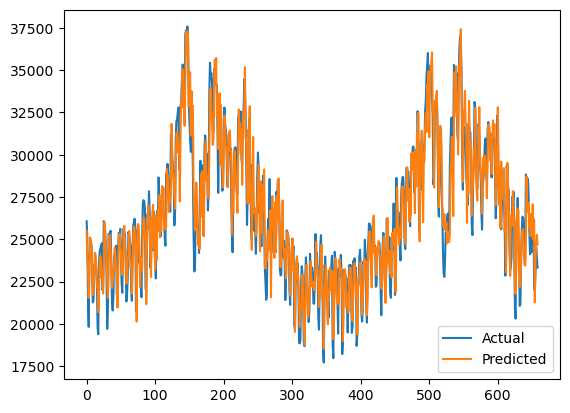

MAPE: 4.626%


In [170]:
plt.plot(yts_stoc, label='Actual')
plt.plot(pred_stoc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_stoc, pred_stoc)*100:.3f}%")

### STLF with Exogenous Variables

In [171]:
stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")

In [172]:
scaler_stmc = MinMaxScaler(feature_range=(0, 1))

sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)

In [173]:
stmc_model = Sequential()
stmc_model.add(InputLayer((SEASON_STLF, 4)))
stmc_model.add(LSTM(512, return_sequences=True))
stmc_model.add(LSTM(256))
stmc_model.add(Dense(32, 'relu'))
stmc_model.add(Dense(4, 'linear'))

stmc_model.summary()

Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_332 (LSTM)                 │ (None, 6, 512)         │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_333 (LSTM)                 │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [174]:
cp = ModelCheckpoint('models/stmc_model.keras', save_best_only=True)
stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.2350 - root_mean_squared_error: 0.4838 - val_loss: 0.1008 - val_root_mean_squared_error: 0.3175
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0720 - root_mean_squared_error: 0.2683 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2682
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0545 - root_mean_squared_error: 0.2328 - val_loss: 0.0528 - val_root_mean_squared_error: 0.2297
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0449 - root_mean_squared_error: 0.2116 - val_loss: 0.0664 - val_root_mean_squared_error: 0.2577
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2637
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0359 - root_mean_squared_error: 0.1894 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2422
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0327 - roo

In [175]:
stmc_model = load_model('models/stmc_model.keras')

pred_stmc = stmc_model.predict(Xts_stmc)
pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]

yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step


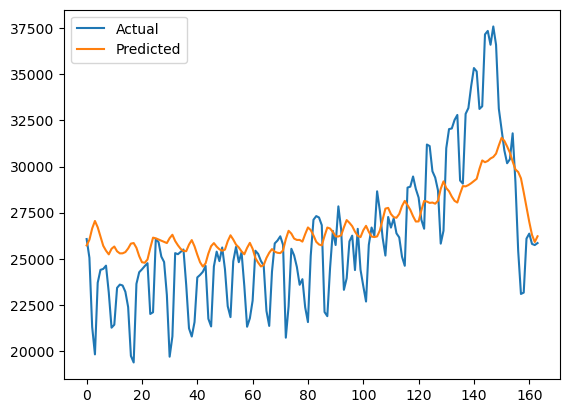

MAPE: 8.871%


In [176]:
plt.plot(yts_stmc, label='Actual')
plt.plot(pred_stmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_stmc, pred_stmc)*100:.3f}%")

## GRU (Gated Recurrent Unit)

### LTLF

In [177]:
scaler_gltoc = MinMaxScaler(feature_range=(0, 1))

In [178]:
agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])

In [179]:
Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)

In [180]:
gltoc_model = Sequential()
gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
gltoc_model.add(GRU(128, return_sequences=True))
gltoc_model.add(GRU(128))
gltoc_model.add(Dense(8, 'relu'))
gltoc_model.add(Dense(1, 'linear'))

In [181]:
cp = ModelCheckpoint('models/gltoc_model.keras', save_best_only=True)
gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [182]:
gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.2222 - root_mean_squared_error: 0.4706 - val_loss: 0.1586 - val_root_mean_squared_error: 0.3982
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0873 - root_mean_squared_error: 0.2954 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.1410 - val_root_mean_squared_error: 0.3755
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0748 - root_mean_squared_error: 0.2734 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3275
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0598 - root_mean_squared_error: 0.2444 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3221
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0642 - root_mean_squared_error: 0.2528 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3213
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0572 - roo

In [183]:
gltoc_model = load_model('models/gltoc_model.keras')

pred_gltoc = gltoc_model.predict(Xts_gltoc)
pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)

yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


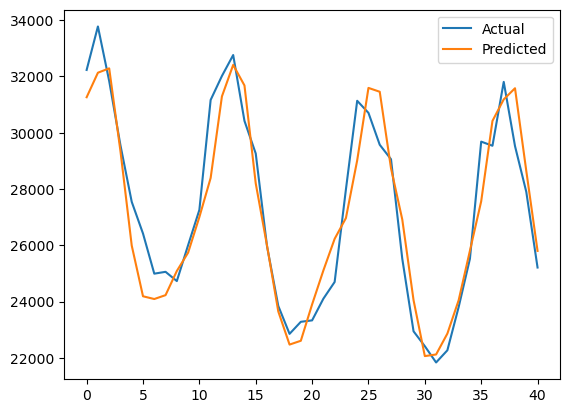

In [184]:
plt.plot(yts_gltoc, label='Actual')
plt.plot(pred_gltoc, label='Predicted')
plt.legend()
plt.show()

In [185]:
print(f"MAPE: {mean_absolute_percentage_error(yts_gltoc, pred_gltoc)*100:.3f}%")

MAPE: 3.305%


### LTLF with Exogenous Variables

In [186]:
scaler_gltmc = MinMaxScaler(feature_range=(0, 1))

sctr_gltmc = scaler_gltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)

In [187]:
gltmc_model = Sequential()
gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
gltmc_model.add(GRU(512, return_sequences=True))
gltmc_model.add(GRU(256))
gltmc_model.add(Dense(32, 'relu'))
gltmc_model.add(Dense(4, 'linear'))

gltmc_model.summary()

Model: "sequential_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_122 (GRU)                   │ (None, 11, 512)        │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_123 (GRU)                   │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
cp = ModelCheckpoint('models/gltmc_model.keras', save_best_only=True)
gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - loss: 0.1851 - root_mean_squared_error: 0.4282 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3548
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0822 - root_mean_squared_error: 0.2865 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2615
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0500 - root_mean_squared_error: 0.2236 - val_loss: 0.0727 - val_root_mean_squared_error: 0.2696
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2151
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0253 - root_mean_squared_error: 0.1589 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1703
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0192 

In [189]:
gltmc_model = load_model('models/gltmc_model.keras')

pred_gltmc = gltmc_model.predict(Xts_gltmc)
pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]

yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


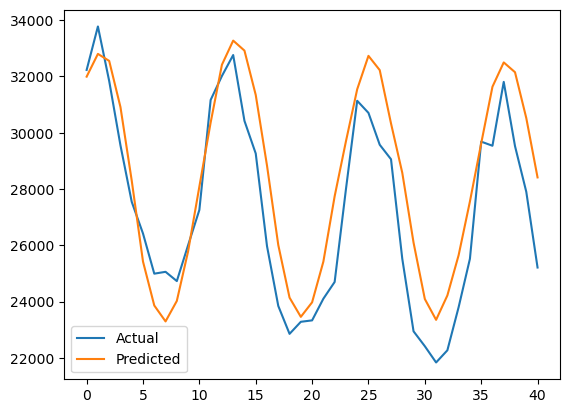

MAPE: 5.743%


In [190]:
plt.plot(yts_gltmc, label='Actual')
plt.plot(pred_gltmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gltmc, pred_gltmc)*100:.3f}%")

### STLF

In [191]:
scaler_gstoc = MinMaxScaler(feature_range=(0, 1))

sctr_gstoc = scaler_gstoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
scvl_gstoc = scaler_gstoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
scts_gstoc = scaler_gstoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)

In [192]:
gstoc_model = Sequential()
gstoc_model.add(InputLayer((SEASON_STLF, 1)))
gstoc_model.add(GRU(128, return_sequences=True))
gstoc_model.add(GRU(128))
gstoc_model.add(Dense(8, 'relu'))
gstoc_model.add(Dense(1, 'linear'))

gstoc_model.summary()

Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_124 (GRU)                   │ (None, 6, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_125 (GRU)                   │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,417 (587.57 KB)

 Trainable params: 150,417 (587.57 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
cp = ModelCheckpoint('models/gstoc_model.keras', save_best_only=True)
gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0453 - root_mean_squared_error: 0.1929 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1394
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - root_mean_squared_error: 0.0561 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1585
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [194]:
gstoc_model = load_model('models/gstoc_model.keras')

pred_gstoc = gstoc_model.predict(Xts_gstoc)
pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)

yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


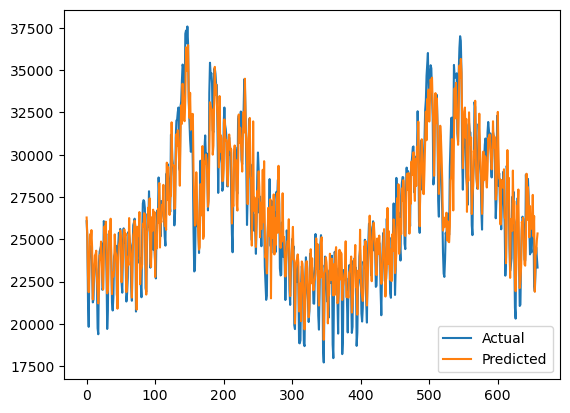

MAPE: 4.732%


In [195]:
plt.plot(yts_gstoc, label='Actual')
plt.plot(pred_gstoc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gstoc, pred_gstoc)*100:.3f}%")

### STLF with Exogenous Variables

In [196]:
scaler_gstmc = MinMaxScaler(feature_range=(0, 1))

sctr_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_gstmc = scaler_gstmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)

In [197]:
gstmc_model = Sequential()
gstmc_model.add(InputLayer((SEASON_STLF, 4)))
gstmc_model.add(GRU(512, return_sequences=True))
gstmc_model.add(GRU(256))
gstmc_model.add(Dense(32, 'relu'))
gstmc_model.add(Dense(4, 'linear'))

gstmc_model.summary()

Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_126 (GRU)                   │ (None, 6, 512)         │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_127 (GRU)                   │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
cp = ModelCheckpoint('models/gstmc_model.keras', save_best_only=True)
gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 0.2299 - root_mean_squared_error: 0.4783 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2903
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2740
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.0726 - val_root_mean_squared_error: 0.2695
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0382 - root_mean_squared_error: 0.1953 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2627
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0538 - val_root_mean_squared_error: 0.2320
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0312 - roo

In [199]:
gstmc_model = load_model('models/gstmc_model.keras')

pred_gstmc = gstmc_model.predict(Xts_gstmc)
pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]

yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


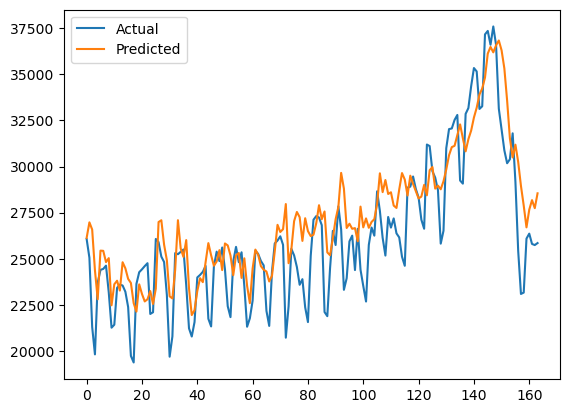

MAPE: 7.197%


In [200]:
plt.plot(yts_gstmc, label='Actual')
plt.plot(pred_gstmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gstmc, pred_gstmc)*100:.3f}%")

## MAPE Averaging

In [201]:
def ltoc_run() -> float:
    scaler_ltoc = MinMaxScaler(feature_range=(0, 1))
    agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
    scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)
    Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
    Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)
    ltoc_model = Sequential()
    ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    ltoc_model.add(LSTM(128, return_sequences=True))
    ltoc_model.add(LSTM(128))
    ltoc_model.add(Dense(8, 'relu'))
    ltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])
    ltoc_model = load_model('intermediate.keras')
    pred_ltoc = ltoc_model.predict(Xts_ltoc)
    pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)
    yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)
   
    return mean_absolute_percentage_error(yts_ltoc, pred_ltoc) * 100

In [202]:
def gltoc_run() -> float:
    scaler_gltoc = MinMaxScaler(feature_range=(0, 1))
    agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
    scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
    Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
    Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)
    gltoc_model = Sequential()
    gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    gltoc_model.add(GRU(128, return_sequences=True))
    gltoc_model.add(GRU(128))
    gltoc_model.add(Dense(8, 'relu'))
    gltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])
    gltoc_model = load_model('intermediate.keras')
    pred_gltoc = gltoc_model.predict(Xts_gltoc)
    pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)
    yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)
   
    return mean_absolute_percentage_error(yts_gltoc, pred_gltoc) * 100

In [203]:
def stoc_run() -> float:
    agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_stoc = MinMaxScaler(feature_range=(0, 1))
    sctr_stoc = scaler_stoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
    scvl_stoc = scaler_stoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
    scts_stoc = scaler_stoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
    Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
    Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)
    stoc_model = Sequential()
    stoc_model.add(InputLayer((SEASON_STLF, 1)))
    stoc_model.add(LSTM(128, return_sequences=True))
    stoc_model.add(LSTM(128))
    stoc_model.add(Dense(8, 'relu'))
    stoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])
    stoc_model = load_model('intermediate.keras')
    pred_stoc = stoc_model.predict(Xts_stoc)
    pred_stoc = scaler_stoc.inverse_transform(pred_stoc)
    yts_stoc = scaler_stoc.inverse_transform(yts_stoc)
    

    return mean_absolute_percentage_error(yts_stoc, pred_stoc) * 100

In [204]:
def gstoc_run() -> float:
    agg_gstoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_gstoc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    scvl_gstoc = scaler_gstoc.fit_transform(agg_gstoc[(agg_gstoc.index >= pd.to_datetime("2022-05-01")) & (agg_gstoc.index < pd.to_datetime("2022-07-15"))])
    scts_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
    Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
    Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)
    gstoc_model = Sequential()
    gstoc_model.add(InputLayer((SEASON_STLF, 1)))
    gstoc_model.add(GRU(128, return_sequences=True))
    gstoc_model.add(GRU(128))
    gstoc_model.add(Dense(8, 'relu'))
    gstoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])
    gstoc_model = load_model('intermediate.keras')
    pred_gstoc = gstoc_model.predict(Xts_gstoc)
    pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)
    yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)
    
    return mean_absolute_percentage_error(yts_gstoc, pred_gstoc) * 100

In [205]:
def ltmc_run() -> float:
    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_ltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
    Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
    Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)
    ltmc_model = Sequential()
    ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    ltmc_model.add(LSTM(512, return_sequences=True))
    ltmc_model.add(LSTM(256))
    ltmc_model.add(Dense(32, 'relu'))
    ltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])
    ltmc_model = load_model('intermediate.keras')
    pred_ltmc = ltmc_model.predict(Xts_ltmc)
    pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]
    yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

    return mean_absolute_percentage_error(yts_ltmc, pred_ltmc) * 100

In [206]:
def gltmc_run() -> float:
    gltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_gltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gltmc = scaler_gltmc.fit_transform(gltmc[gltmc.index < pd.to_datetime("2017-01-01")])
    scvl_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2017-01-01")) & (gltmc.index < pd.to_datetime("2020-01-01"))])
    scts_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2020-01-01")) & (gltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
    Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
    Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)
    gltmc_model = Sequential()
    gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    gltmc_model.add(LSTM(512, return_sequences=True))
    gltmc_model.add(LSTM(256))
    gltmc_model.add(Dense(32, 'relu'))
    gltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])
    gltmc_model = load_model('intermediate.keras')
    pred_gltmc = gltmc_model.predict(Xts_gltmc)
    pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]
    yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

    return mean_absolute_percentage_error(yts_gltmc, pred_gltmc) * 100

In [207]:
def stmc_run():
    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")
    scaler_stmc = MinMaxScaler(feature_range=(0, 1))
    sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
    Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
    Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)
    stmc_model = Sequential()
    stmc_model.add(InputLayer((SEASON_STLF, 4)))
    stmc_model.add(LSTM(512, return_sequences=True))
    stmc_model.add(LSTM(256))
    stmc_model.add(Dense(32, 'relu'))
    stmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])
    stmc_model = load_model('intermediate.keras')
    pred_stmc = stmc_model.predict(Xts_stmc)
    pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]
    yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

    return mean_absolute_percentage_error(yts_stmc, pred_stmc) * 100

In [208]:
def gstmc_run():
    gstmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")
    scaler_gstmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index < pd.to_datetime("2022-05-01")])
    scvl_gstmc = scaler_gstmc.fit_transform(gstmc[(gstmc.index >= pd.to_datetime("2022-05-01")) & (gstmc.index < pd.to_datetime("2022-07-15"))])
    scts_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
    Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
    Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)
    gstmc_model = Sequential()
    gstmc_model.add(InputLayer((SEASON_STLF, 4)))
    gstmc_model.add(LSTM(512, return_sequences=True))
    gstmc_model.add(LSTM(256))
    gstmc_model.add(Dense(32, 'relu'))
    gstmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])
    gstmc_model = load_model('intermediate.keras')
    pred_gstmc = gstmc_model.predict(Xts_gstmc)
    pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]
    yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

    return mean_absolute_percentage_error(yts_gstmc, pred_gstmc) * 100

In [209]:
results = {
    "ltoc":[], "gltoc":[], "stoc":[], "gstoc":[], "ltmc":[], "gltmc":[], "stmc":[], "gstmc":[]
    }

In [210]:
for i in range(15):
    results["ltoc"].append(ltoc_run())

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.2825 - root_mean_squared_error: 0.5311 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5221
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854 - val_loss: 0.2436 - val_root_mean_squared_error: 0.4936
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469 - val_loss: 0.1900 - val_root_mean_squared_error: 0.4359
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1526 - root_mean_squared_error: 0.3896 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3434
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0651 - root_mean_squared_error: 0.2550 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0866 - root_mean_squared_error: 0.2940 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0611 - roo

In [212]:
for i in range(15):
    results["gltoc"].append(gltoc_run())


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - loss: 0.2579 - root_mean_squared_error: 0.5078 - val_loss: 0.2602 - val_root_mean_squared_error: 0.5101
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2102 - root_mean_squared_error: 0.4581 - val_loss: 0.2363 - val_root_mean_squared_error: 0.4861
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1884 - root_mean_squared_error: 0.4337 - val_loss: 0.2024 - val_root_mean_squared_error: 0.4498
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1509 - root_mean_squared_error: 0.3885 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3925
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0928 - root_mean_squared_error: 0.3047 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3358
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593 - val_loss: 0.1457 - val_root_mean_squared_error: 0.3817
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0835 - ro

In [245]:
for i in range(15):
    results["stoc"].append(stoc_run())
    print(i)


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0581 - root_mean_squared_error: 0.2251 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2397
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0571 - val_root_mean_squared_error: 0.2390
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2259
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1836
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [232]:
for i in range(15):
    results["gstoc"].append(gstoc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.2410 - root_mean_squared_error: 0.4896 - val_loss: 0.0569 - val_root_mean_squared_error: 0.2385
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0360 - root_mean_squared_error: 0.1894 - val_loss: 0.1044 - val_root_mean_squared_error: 0.3231
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0590 - root_mean_squared_error: 0.2425 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0223 - root_mean_squared_error: 0.1491 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2394
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0389 - root_mean_squared_error: 0.1970 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2349
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2309
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0237 - roo

In [215]:
for i in range(15):
    results["ltmc"].append(ltmc_run())
    print(i)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.2266 - root_mean_squared_error: 0.4758 - val_loss: 0.1771 - val_root_mean_squared_error: 0.4209
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1273 - root_mean_squared_error: 0.3565 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3351
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0786 - root_mean_squared_error: 0.2802 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2917
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0673 - root_mean_squared_error: 0.2594 - val_loss: 0.0762 - val_root_mean_squared_error: 0.2760
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0499 

In [216]:
for i in range(15):
    results["gltmc"].append(gltmc_run())
    print(i)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - loss: 0.1810 - root_mean_squared_error: 0.4250 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3225
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0736 - root_mean_squared_error: 0.2712 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2920
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.1039 - val_root_mean_squared_error: 0.3224
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0697 - root_mean_squared_error: 0.2639 - val_loss: 0.0858 - val_root_mean_squared_error: 0.2928
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2926
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2799
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0525 - 

In [217]:
for i in range(15):
    results["stmc"].append(stmc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.1886 - root_mean_squared_error: 0.4325 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2975
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0784 - root_mean_squared_error: 0.2794 - val_loss: 0.0814 - val_root_mean_squared_error: 0.2852
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0588 - root_mean_squared_error: 0.2424 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0424 - root_mean_squared_error: 0.2055 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2559
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2382
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0340 - roo

In [218]:
for i in range(15):
    results["gstmc"].append(gstmc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.2078 - root_mean_squared_error: 0.4541 - val_loss: 0.0771 - val_root_mean_squared_error: 0.2777
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0680 - root_mean_squared_error: 0.2606 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2721
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2714
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2342
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0325 - root_mean_squared_error: 0.1801 - val_loss: 0.0681 - val_root_mean_squared_error: 0.2609
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0333 - roo

In [250]:
mean_list = [np.mean(results["ltoc"]), np.mean(results["gltoc"]), np.mean(results["stoc"]), np.mean(results["gstoc"]), 
np.mean(results["ltmc"]), np.mean(results["gltmc"]), np.mean(results["stmc"]), np.mean(results["gstmc"])]

mean_list

[3.9398934274077235,
 3.246422811156406,
 4.774558596377669,
 6.520666214466544,
 7.0820280159042985,
 7.241012849284248,
 9.542898512019125,
 8.773331698280268]

In [251]:
std_list = [np.std(results["ltoc"]), np.std(results["gltoc"]), np.std(results["stoc"]), np.std(results["gstoc"]), 
np.std(results["ltmc"]), np.std(results["gltmc"]), np.std(results["stmc"]), np.std(results["gstmc"])]

std_list

[0.8284301929700736,
 0.24321273199237317,
 0.200225718288764,
 0.4399720496446394,
 0.8206419010028283,
 1.369446244354824,
 1.9370215733765481,
 1.4725708828192492]

In [252]:
def conf_interval_15(mean: float, std: float) -> (float, float):
    return (mean - std * 2.131, mean, mean + std * 2.131)

In [253]:
for m, s in zip(mean_list, std_list):
    print(conf_interval_15(m, s))

(2.1745086861884966, 3.9398934274077235, 5.7052781686269505)
(2.728136479280659, 3.246422811156406, 3.764709143032153)
(4.347877590704313, 4.774558596377669, 5.201239602051025)
(5.583085776673818, 6.520666214466544, 7.4582466522592705)
(5.333240124867272, 7.0820280159042985, 8.830815906941325)
(4.322722902564118, 7.241012849284248, 10.159302796004377)
(5.415105539153702, 9.542898512019125, 13.670691484884548)
(5.635283146992448, 8.773331698280268, 11.911380249568088)
